In [ ]:
# The original model is in the Forecasting model file
# This script retrain the model with the data from '2022-04-01' to '2023-01-31'.

In [1]:
%matplotlib inline
from itertools import chain
import logging
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import datetime
from scipy.interpolate import interp2d
from scipy.integrate import odeint
import matplotlib.dates as mdates
import seaborn as sb
from pyomo.environ import *
import pandas as pd
import pyomo.environ as pyo
from pyomo.util.infeasible import log_infeasible_constraints
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import json
import requests
import io
import holidays
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
filename_rf = '20230212_kropman_building_rf_22_23.sav'
filename_xgb = '20230212_kropman_building_xgb_22_23.sav'

In [2]:
train_fromtime = '2022-04-01'
train_totime = '2023-01-31'

# Load data

In [3]:
# Credentials Kropman
creds = json.load(open("creds.txt"))
serverpath = r'https://portal.insitereports.nl/data.php?'
r = requests.post(serverpath+'action=login', data=creds)
get_token = r.json()

In [4]:
def request_data_insitereports(creds:dict, report_id:int, from_date:str, to_date:str) -> pd.DataFrame:
    if(get_token['success'] == True):
        token = get_token['token']
        report = requests.get(serverpath + 'action=getdata&token=' + str(token) + '&report='+ str(report_id) + '&from=' + 
                              str(from_date) + '&to=' + str(to_date) + '&output=csv')
        textfile = report.text
        textfile = io.StringIO(textfile)
        data = pd.read_csv(textfile, sep=';', parse_dates=True, index_col='Tijdpunten [jaar-maand-dag uur:min:sec]')
        return data
    else:
        print(get_token['error'])

In [5]:
# loading data
df_request_building = request_data_insitereports(creds, 30881, train_fromtime, train_totime)
df_request_weather = request_data_insitereports(creds, 29025, train_fromtime, train_totime)
df_predict_building = request_data_insitereports(creds, 30881, train_fromtime, train_totime)
df_predict_weather = request_data_insitereports(creds, 35941, train_fromtime, train_totime)
#!!! df_predict_pv = request_data_insitereports(creds, [code for pv forecast data], '2022-03-10', '2023-01-31')
df_actual = request_data_insitereports(creds, 30881, train_fromtime, train_totime)

In [6]:
# organizing data

df_request_building.index = pd.to_datetime(df_request_building.index, format='%Y-%m-%d %H:%M:%S')
df_request_building.columns = ['HV Kracht', 'PV', 'BESS', 'EV1', 'EV2', 'HV Licht']
df_request_building['EV1'] = df_request_building['EV1'] / 1000
df_request_building['EV2'] = df_request_building['EV2'] / 1000

df_request_weather.index = pd.to_datetime(df_request_weather.index, format='%Y-%m-%d %H:%M:%S')
df_request_weather.columns = ['TEMP', 'GHI']

df_predict_building.columns = ['HV Kracht', 'PV', 'BESS', 'EV1', 'EV2', 'HV Licht']
df_predict_building['EV1'] = df_predict_building['EV1'] / 1000
df_predict_building['EV2'] = df_predict_building['EV2'] / 1000


df_actual.index = pd.to_datetime(df_actual.index, format='%Y-%m-%d %H:%M:%S')
df_actual.columns = ['HV Kracht', 'PV', 'BESS', 'EV1', 'EV2', 'HV Licht']
df_actual['EV1'] = df_actual['EV1'] / 1000
df_actual['EV2'] = df_actual['EV2'] / 1000

The calculation of building load: (system structure is missing)\
Building load = HV Kracht – PV – BESS – EV1 – EV2 + HV Licht

In [7]:
# pre-processing and feature preperation functions

def data_preprocessing(df_request_building, df_request_weather):
    # Check for NaN values in datasets.
    def nan_values(df):
        nans = df.isnull().sum()
        return nans

    nans_df_request_building = nan_values(df_request_building)
    nans_df_request_weather = nan_values(df_request_weather)
    
    
    # Resample datasets to 15 min time intervals.
    def resampling(df_request_building, df_request_weather):
        df_building_resampled = df_request_building.resample('5 min', closed='left', label='right').mean()
        df_weather_resampled = df_request_weather.resample('5 min', closed='left', label='right').mean()
        return df_building_resampled, df_weather_resampled

    df_building_resampled, df_weather_resampled = resampling(df_request_building, df_request_weather)

    # Re-evaluate NaN values in datasets after resampling.
    nans_df_building_resampled = nan_values(df_building_resampled)
    nans_df_weather_resampled = nan_values(df_weather_resampled)
    
    # Fill NaN values in datasets unless there are more than sixteen executive NaN values. Then the missing gap is too 
    # large.
    def fill_nan_values(series, df):
        if np.count_nonzero(series) != 0:
            df.interpolate(method='linear', limit=16, inplace=True, )
        else:
            pass
        return df

    df_building_resampled = fill_nan_values(nans_df_building_resampled, df_building_resampled)
    df_weather_resampled = fill_nan_values(nans_df_weather_resampled, df_weather_resampled)
    
    # BESS minus of plus?
    df_building_resampled['Building load'] = (df_building_resampled['HV Kracht'] - df_building_resampled['PV'] - 
                                              df_building_resampled['BESS'] - df_building_resampled['EV1'] - 
                                              df_building_resampled['EV2'] + df_building_resampled['HV Licht'])
    
    return df_building_resampled, df_weather_resampled

def prediction_features(df_building_predict, df_weather_predict):
    df_weather_nextday = df_weather_predict.iloc[2016:2304].copy()
    nl_holidays = []
    for date in holidays.Netherlands(years=[2022,2023]).items():
        nl_holidays.append(str(date[0]))
    X_predict = df_weather_nextday
    X_predict['Building load previous day'] = df_building_predict['Building load'][576:672].values
    X_predict['Building load previous week'] = df_building_predict['Building load'][:96].values
    X_predict['Hour of day'] = X_predict.index.hour
    X_predict['Minute of hour'] = X_predict.index.minute
    X_predict['Fraction of hour'] = X_predict['Minute of hour'] / 60
    X_predict['Time of day'] = X_predict['Hour of day'] + X_predict['Fraction of hour']
    X_predict['Day of week'] = X_predict.index.weekday
    X_predict['Month'] = X_predict.index.month
    X_predict['Dates'] = X_predict.index.date
    X_predict['Holiday'] = [1 if str(val) in nl_holidays else 0 for val in X_predict['Dates']]
    X_predict.drop(['Hour of day', 'Minute of hour', 'Fraction of hour', 'Dates'], axis=1, inplace=True)
    
    return X_predict


def features(df_features):
    nl_holidays = []
    for date in holidays.Netherlands(years=[2022,2023]).items():
        nl_holidays.append(str(date[0]))
    X = df_features
    X['Building load previous day'] = X['Building load'].shift(288)
    X['Building load previous week'] = X['Building load'].shift(2016)
    X['Hour of day'] = X.index.hour
    X['Minute of hour'] = X.index.minute
    X['Fraction of hour'] = X['Minute of hour'] / 60
    X['Time of day'] = X['Hour of day'] + X['Fraction of hour']
    X['Day of week'] = X.index.weekday
    X['Month'] = X.index.month
    X['Dates'] = X.index.date
    X['Holiday'] = [1 if str(val) in nl_holidays else 0 for val in X['Dates']]
    X.dropna(inplace=True)
    y = X['Building load']
    X.drop(['Hour of day', 'Minute of hour', 'Fraction of hour', 'Building load', 'Dates'], axis=1, inplace=True)
    return X, y

In [8]:
# pre-processing data
df_building, df_weather = data_preprocessing(df_request_building, df_request_weather)

Text(0.5, 0, 'Datetime [yyyy-mm-dd]')

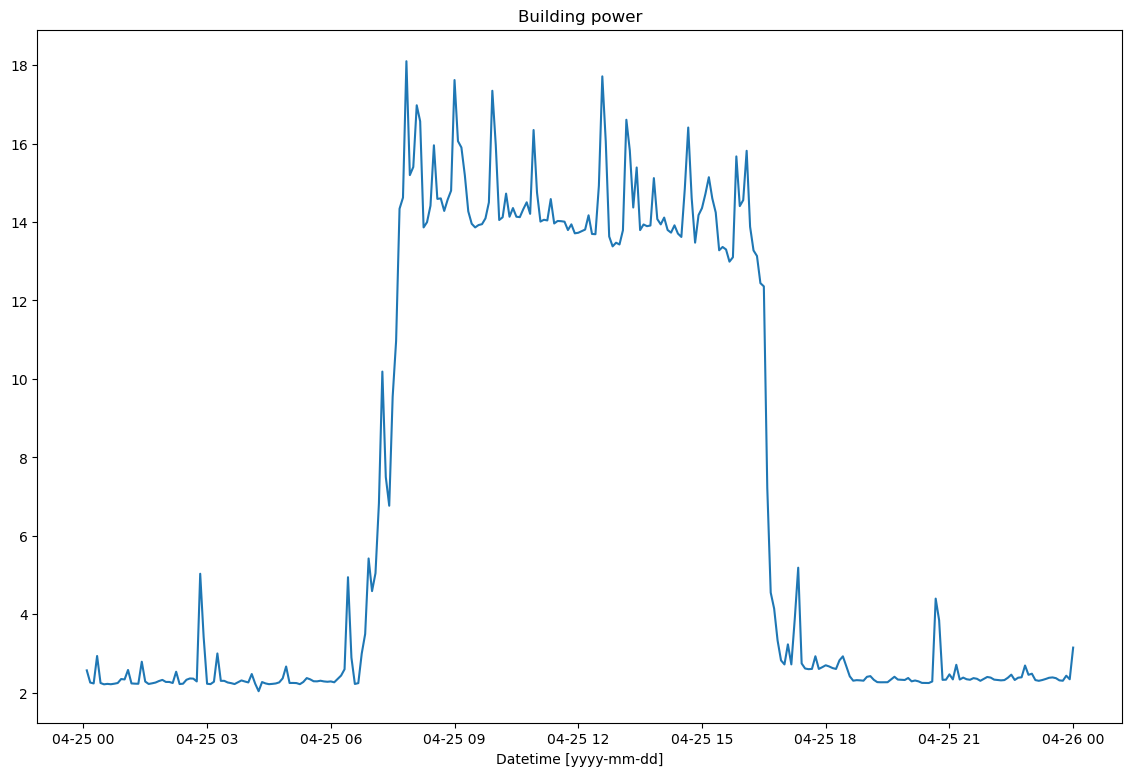

In [17]:
### only to check the calculation of the building load
checking_fromtime = '2022-04-25 00:00'
checking_totime = '2022-04-26 00:00'
mask = (df_building.index > checking_fromtime) & (df_building.index <= checking_totime)
#df_building = df_building[mask]
plt.figure(figsize=(14,9))
plt.plot(df_building['Building load'][mask])
plt.title('Building power')
plt.xlabel('power (kW)')
plt.xlabel('Datetime [yyyy-mm-dd]')

In [9]:
# building load will start from 5 mins after the starting time
# whether will start from 15 mins after the starting time
df_features = pd.concat([df_building['Building load'], df_weather], axis=1)
df_features['TEMP'] = df_features['TEMP'].fillna(method='bfill')
df_features['GHI'] = df_features['GHI'].fillna(method='bfill')

# some negative load caused by reactive power are replaced by 0
#df_features[df_features < 0] = 0
df_features

,Building load,TEMP,GHI
Tijdpunten [jaar-maand-dag uur:min:sec],,,
2022-04-01 00:05:00,2.5306,1.0,0.0
2022-04-01 00:10:00,2.5636,1.0,0.0
2022-04-01 00:15:00,2.5448,1.0,0.0
2022-04-01 00:20:00,2.5510,1.0,0.0
2022-04-01 00:25:00,3.1456,1.0,0.0
...,...,...,...
2023-01-31 23:40:00,1.7260,5.0,0.0
2023-01-31 23:45:00,1.7190,5.0,0.0
2023-01-31 23:50:00,1.6776,5.0,0.0


In [10]:
#X_predict = prediction_features(df_building_predict, df_weather_predict)
X, y = features(df_features)
X

,TEMP,GHI,Building load previous day,Building load previous week,Time of day,Day of week,Month,Holiday
Tijdpunten [jaar-maand-dag uur:min:sec],,,,,,,,
2022-04-08 00:05:00,6.666667,0.0,2.2970,2.5306,0.083333,4,4,0
2022-04-08 00:10:00,6.333333,0.0,2.2538,2.5636,0.166667,4,4,0
2022-04-08 00:15:00,6.000000,0.0,2.2248,2.5448,0.250000,4,4,0
2022-04-08 00:20:00,6.000000,0.0,2.2818,2.5510,0.333333,4,4,0
2022-04-08 00:25:00,6.000000,0.0,2.2544,3.1456,0.416667,4,4,0
...,...,...,...,...,...,...,...,...
2023-01-31 23:40:00,5.000000,0.0,2.7138,1.9660,23.666667,1,1,0
2023-01-31 23:45:00,5.000000,0.0,1.6206,1.5204,23.750000,1,1,0
2023-01-31 23:50:00,5.000000,0.0,1.6138,1.5962,23.833333,1,1,0


# Train model

In [18]:
filename_rf_param = '20230212_kropman_building_rf_22_23_param_0.sav'
filename_rf_model = '20230510_kropman_building_rf_22_23_model_0.sav'

In [19]:
# training and testing dataset
def train_test_splitting(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    return X_train, X_test, y_train, y_test

#X_train, X_test, y_train, y_test = train_test_splitting(X, y)

# MODEL BUILDER - 1 (randomsearch)
# Hyperparameter optimisation of Random Forest algorithm with the use of RandomSearchCV. Moreover, RepeatedKFold, a cross-
# validation method, is used to avoid overfitting.
def randomsearch_rf(X_train, y_train):
    model_rf = RandomForestRegressor()
    n_estimators = np.arange(50, 210, 10)
    max_depth = np.arange(10, 110, 10)
    max_depth = np.append(max_depth, None)
    min_samples_split = np.arange(1, 11, 1)
    min_samples_leaf = np.arange(1, 11, 1)
    max_features = ['auto', 'sqrt']
    bootstrap = [True, False]
    random_state = [0]
    param_distributions = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, 
                               random_state=random_state)
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    randomsearch = RandomizedSearchCV(estimator=model_rf, n_jobs=-1, cv=cv, param_distributions=param_distributions,
                                      scoring='neg_root_mean_squared_error')
    randomsearch_results = randomsearch.fit(X_train, y_train)
    model_rf.set_params(**randomsearch_results.best_params_)
    pickle.dump(model_rf, open(filename_rf_param, 'wb'))
    return model_rf

randomsearch_rf(X, y)

C:\Users\Rachel\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Rachel\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Rachel\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Rachel\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Rachel\anaconda3\lib\site-packa

RandomForestRegressor(bootstrap=False, max_depth=40, min_samples_leaf=6,
                      min_samples_split=10, n_estimators=180, random_state=0)

In [1]:
model_rf = pickle.load(open(filename_rf_param, 'rb'))
model_rf.fit(X,y)
pickle.dump(model_rf, open(filename_rf_model, 'wb'))

NameError: name 'pickle' is not defined

# START HERE - Load the built model and do the forecasting

In [11]:
# load the built model
filename_rf_model = '20230510_kropman_building_rf_22_23_model_0.sav'
model_rf = pickle.load(open(filename_rf_model, 'rb'))

Load and prepare the features for forecasting... (from '2022-03-01' to '2022-03-31')

In [12]:
# Credentials Kropman
creds = json.load(open("creds.txt"))
serverpath = r'https://portal.insitereports.nl/data.php?'
r = requests.post(serverpath+'action=login', data=creds)
get_token = r.json()

In [13]:
def request_data_insitereports(creds:dict, report_id:int, from_date:str, to_date:str) -> pd.DataFrame:
    if(get_token['success'] == True):
        token = get_token['token']
        report = requests.get(serverpath + 'action=getdata&token=' + str(token) + '&report='+ str(report_id) + '&from=' + 
                              str(from_date) + '&to=' + str(to_date) + '&output=csv')
        textfile = report.text
        textfile = io.StringIO(textfile)
        data = pd.read_csv(textfile, sep=';', parse_dates=True, index_col='Tijdpunten [jaar-maand-dag uur:min:sec]')
        return data
    else:
        print(get_token['error'])

In [14]:
testing_fromtime = '2022-03-10'
testing_totime = '2022-03-31'

In [15]:
# loading data
df_request_building = request_data_insitereports(creds, 30881, testing_fromtime, testing_totime)
df_request_weather = request_data_insitereports(creds, 29025, testing_fromtime, testing_totime)
df_predict_weather = request_data_insitereports(creds, 35941, testing_fromtime, testing_totime)
#!!! df_predict_pv = request_data_insitereports(creds, [code for pv forecast data], '2022-03-10', '2023-01-31')


# organizing data

df_request_building.index = pd.to_datetime(df_request_building.index, format='%Y-%m-%d %H:%M:%S')
df_request_building.columns = ['HV Kracht', 'PV', 'BESS', 'EV1', 'EV2', 'HV Licht']
df_request_building['EV1'] = df_request_building['EV1'] / 1000
df_request_building['EV2'] = df_request_building['EV2'] / 1000

df_request_weather.index = pd.to_datetime(df_request_weather.index, format='%Y-%m-%d %H:%M:%S')
df_request_weather.columns = ['TEMP', 'GHI']

df_predict_building.columns = ['HV Kracht', 'PV', 'BESS', 'EV1', 'EV2', 'HV Licht']
df_predict_building['EV1'] = df_predict_building['EV1'] / 1000
df_predict_building['EV2'] = df_predict_building['EV2'] / 1000


df_actual.index = pd.to_datetime(df_actual.index, format='%Y-%m-%d %H:%M:%S')
df_actual.columns = ['HV Kracht', 'PV', 'BESS', 'EV1', 'EV2', 'HV Licht']
df_actual['EV1'] = df_actual['EV1'] / 1000
df_actual['EV2'] = df_actual['EV2'] / 1000

df_request_building

,HV Kracht,PV,BESS,EV1,EV2,HV Licht
Tijdpunten [jaar-maand-dag uur:min:sec],,,,,,
2022-03-10 00:00:00,1.89,0.004,0.001,-0.005,0.029,0.373
2022-03-10 00:01:00,1.80,0.006,0.001,-0.004,0.030,0.374
2022-03-10 00:02:00,1.80,0.006,0.000,-0.005,0.029,0.374
2022-03-10 00:03:00,1.80,0.006,0.000,-0.004,0.031,0.376
2022-03-10 00:04:00,1.80,0.006,0.001,-0.005,0.028,0.374
...,...,...,...,...,...,...
2022-03-31 23:55:00,1.89,0.006,0.001,-0.004,0.030,0.377
2022-03-31 23:56:00,1.90,0.006,0.001,-0.006,0.031,0.377
2022-03-31 23:57:00,1.90,0.006,0.001,-0.003,0.031,0.378


In [16]:
# pre-processing and feature preperation functions

def data_preprocessing(df_request_building, df_request_weather):
    # Check for NaN values in datasets.
    def nan_values(df):
        nans = df.isnull().sum()
        return nans

    nans_df_request_building = nan_values(df_request_building)
    nans_df_request_weather = nan_values(df_request_weather)
    
    
    # Resample datasets to 15 min time intervals.
    def resampling(df_request_building, df_request_weather):
        df_building_resampled = df_request_building.resample('5 min', closed='left', label='right').mean()
        df_weather_resampled = df_request_weather.resample('5 min', closed='left', label='right').mean()
        return df_building_resampled, df_weather_resampled

    df_building_resampled, df_weather_resampled = resampling(df_request_building, df_request_weather)

    # Re-evaluate NaN values in datasets after resampling.
    nans_df_building_resampled = nan_values(df_building_resampled)
    nans_df_weather_resampled = nan_values(df_weather_resampled)
    
    # Fill NaN values in datasets unless there are more than sixteen executive NaN values. Then the missing gap is too 
    # large.
    def fill_nan_values(series, df):
        if np.count_nonzero(series) != 0:
            df.interpolate(method='linear', limit=16, inplace=True, )
        else:
            pass
        return df

    df_building_resampled = fill_nan_values(nans_df_building_resampled, df_building_resampled)
    df_weather_resampled = fill_nan_values(nans_df_weather_resampled, df_weather_resampled)
    
    # BESS minus of plus?
    df_building_resampled['Building load'] = (df_building_resampled['HV Kracht'] - df_building_resampled['PV'] - 
                                              df_building_resampled['BESS'] - df_building_resampled['EV1'] - 
                                              df_building_resampled['EV2'] + df_building_resampled['HV Licht'])
    
    return df_building_resampled, df_weather_resampled

def prediction_features(df_building_predict, df_weather_predict):
    df_weather_nextday = df_weather_predict.iloc[2016:2304].copy()
    nl_holidays = []
    for date in holidays.Netherlands(years=[2022,2023]).items():
        nl_holidays.append(str(date[0]))
    X_predict = df_weather_nextday
    X_predict['Building load previous day'] = df_building_predict['Building load'][576:672].values
    X_predict['Building load previous week'] = df_building_predict['Building load'][:96].values
    X_predict['Hour of day'] = X_predict.index.hour
    X_predict['Minute of hour'] = X_predict.index.minute
    X_predict['Fraction of hour'] = X_predict['Minute of hour'] / 60
    X_predict['Time of day'] = X_predict['Hour of day'] + X_predict['Fraction of hour']
    X_predict['Day of week'] = X_predict.index.weekday
    X_predict['Month'] = X_predict.index.month
    X_predict['Dates'] = X_predict.index.date
    X_predict['Holiday'] = [1 if str(val) in nl_holidays else 0 for val in X_predict['Dates']]
    X_predict.drop(['Hour of day', 'Minute of hour', 'Fraction of hour', 'Dates'], axis=1, inplace=True)
    
    return X_predict


def features(df_features):
    nl_holidays = []
    for date in holidays.Netherlands(years=[2022,2023]).items():
        nl_holidays.append(str(date[0]))
    X = df_features
    X['Building load previous day'] = X['Building load'].shift(288)
    X['Building load previous week'] = X['Building load'].shift(2016)
    X['Hour of day'] = X.index.hour
    X['Minute of hour'] = X.index.minute
    X['Fraction of hour'] = X['Minute of hour'] / 60
    X['Time of day'] = X['Hour of day'] + X['Fraction of hour']
    X['Day of week'] = X.index.weekday
    X['Month'] = X.index.month
    X['Dates'] = X.index.date
    X['Holiday'] = [1 if str(val) in nl_holidays else 0 for val in X['Dates']]
    X.dropna(inplace=True)
    y = X['Building load']
    X.drop(['Hour of day', 'Minute of hour', 'Fraction of hour', 'Building load', 'Dates'], axis=1, inplace=True)
    return X, y

In [17]:
# pre-processing data
df_building, df_weather = data_preprocessing(df_request_building, df_request_weather)

# df_building and df_weather will have 10 mins deviation

In [18]:
# building load will start from 5 mins after the starting time
# whether will start from 15 mins after the starting time
df_features = pd.concat([df_building['Building load'], df_weather], axis=1)
df_features = df_features.rename(columns={"Temperatuur - Voorspelling Actueel [15min] [TE15-NEW] [°C]":"TEMP", "Globale straling - Voorspelling Actueel [15min] [GH15-NEW] [W/m²]":"GHI"})

df_features['TEMP'] = df_features['TEMP'].fillna(method='bfill')
df_features['GHI'] = df_features['GHI'].fillna(method='bfill')

X, y = features(df_features)

In [19]:
# predic
building_load_predicted = model_rf.predict(X)

df_predict_load = pd.DataFrame(index=X.index)
df_predict_load['Load'] = building_load_predicted.tolist()
df_predict_load

,Load
Tijdpunten [jaar-maand-dag uur:min:sec],
2022-03-17 00:05:00,2.324033
2022-03-17 00:10:00,2.324033
2022-03-17 00:15:00,2.324033
2022-03-17 00:20:00,2.324033
2022-03-17 00:25:00,2.324033
...,...
2022-03-31 23:40:00,2.207000
2022-03-31 23:45:00,2.194467
2022-03-31 23:50:00,2.905233


In [20]:
# visualization functions
def plot_actual_predicted(actual, predicted):
    fig, ax = plt.subplots(1, 1,figsize=(16,8))
    line1, =plt.plot(actual.index, actual, label='Actual power demand', color='C0')
    line2, =plt.plot(actual.index, predicted, label='Predicted power demand', color='C1')
    plt.xlabel('Datetime [yyyy-mm-dd]', fontsize=18)
    plt.yticks(range(0, 25, 5))
    plt.ylabel('Power demand [kW]', fontsize=18)
    plt.legend([line1, line2], ['Actual power demand', 'Predicted power demand'], fontsize=18)
    plt.grid()
    return fig, ax

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot:xlabel='Datetime [yyyy-mm-dd]', ylabel='Power demand [kW]'>)

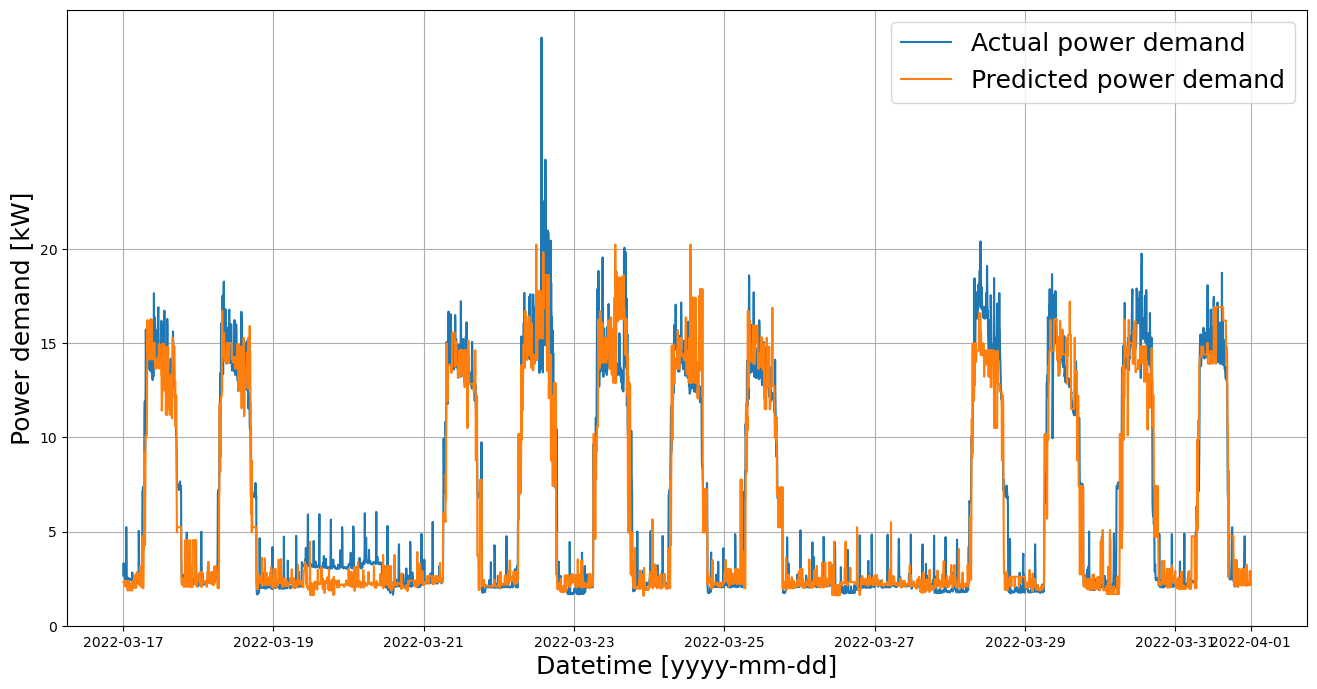

In [21]:
plot_actual_predicted(y, df_predict_load['Load'])

In [22]:
# evaluation of prediction model
def error_metrics(actual, predicted):  
    RMSE = (mean_squared_error(actual, predicted, squared=False))
    MAE = (mean_absolute_error(actual, predicted))
    NRMSE = (mean_squared_error(actual, predicted, squared=False)) / (actual.max()-actual.min())
    return [RMSE, MAE, NRMSE]

error_metrics_rf_train = error_metrics(y, building_load_predicted)
error_metrics_rf_test = error_metrics(y, building_load_predicted)
print('RMSE = ', error_metrics_rf_test[0], ',MAE = ', error_metrics_rf_test[1], ',NRMSE = ', error_metrics_rf_test[2])
print('building load range = (', max(y), ', ', min(y), ') (kWh)')

RMSE =  1.7095866548418064 ,MAE =  1.0564373493416632 ,NRMSE =  0.057816466283896965
building load range = ( 31.214800000000004 ,  1.6455999999999995 ) (kWh)


# evaluation for training stage

In [73]:
def forecasting(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    predicted_train = model.predict(X_train)
    predicted_test = model.predict(X_test)
    return predicted_train, predicted_test

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot:xlabel='Datetime [yyyy-mm-dd]', ylabel='Power demand [kW]'>)

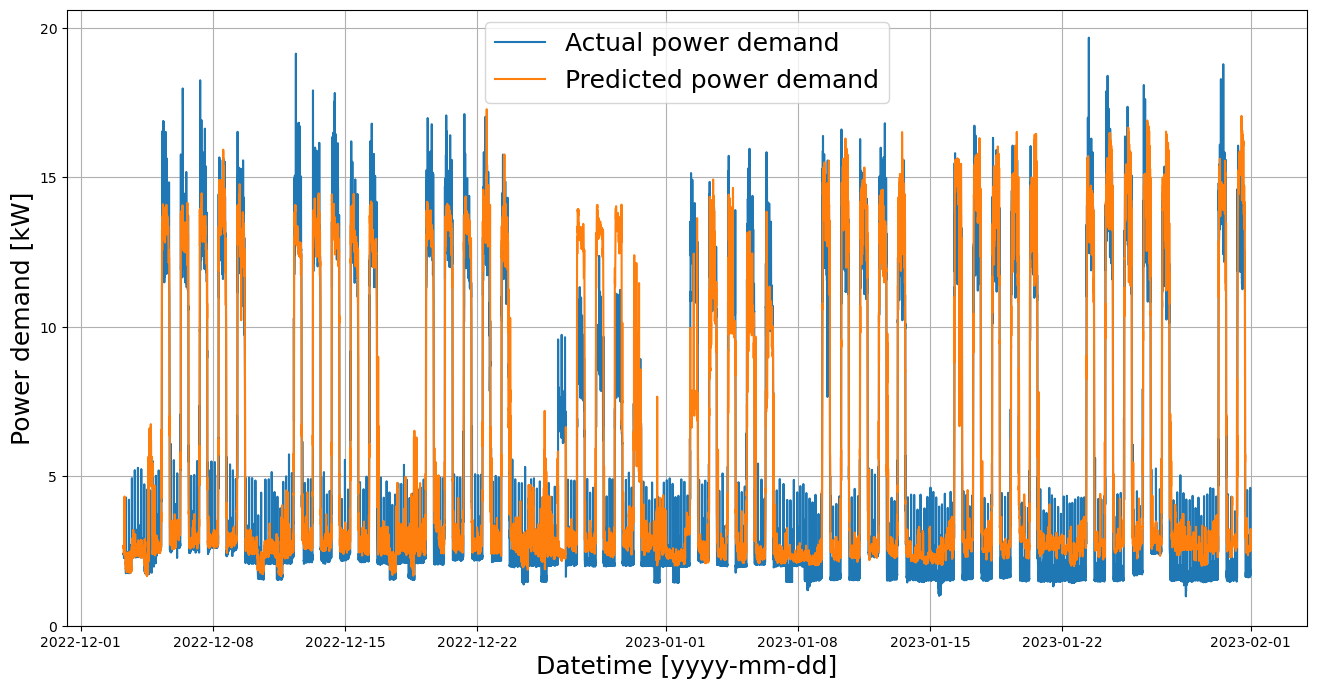

In [75]:
predicted_train_rf, predicted_test_rf = forecasting(model_rf, X_train, y_train, X_test)
plot_actual_predicted(y_test, predicted_test_rf)

In [76]:
# evaluation of prediction model
def error_metrics(actual, predicted):  
    RMSE = (mean_squared_error(actual, predicted, squared=False))
    MAE = (mean_absolute_error(actual, predicted))
    NRMSE = (mean_squared_error(actual, predicted, squared=False)) / (actual.max()-actual.min())
    return [RMSE, MAE, NRMSE]

error_metrics_rf_train = error_metrics(y_train, predicted_train_rf)
error_metrics_rf_test = error_metrics(y_test, predicted_test_rf)
print('RMSE = ', error_metrics_rf_test[0], ',MAE = ', error_metrics_rf_test[1], ',NRMSE = ', error_metrics_rf_test[2])
print('building load range = (', max(y), ', ', min(y), ') (kWh)')

RMSE =  1.5407202520741654 ,MAE =  1.091459951233691 ,NRMSE =  0.08241701982829784
building load range = ( 40.0714 ,  -0.7323999999999999 ) (kWh)
